# Calling from Python

Calling Julia and CMBLensing.jl directly from Python is very transparent. This is made possible by the [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) package. You can install it into your Python environment with, e.g.:

```shell
$ pip install --user julia
```

**Important:** If your Python executable is statically-linked (this is quite often the case, e.g. its the default on Ubuntu and Conda) you need one extra step. Basically, instead of running `python` or `ipython` at the command line to launch your interpreter, run `python-jl`  or `python-jl -m IPython`, respectively. If you use Jupyter, you'll need to edit your `kernel.json` file (you can find its location via `jupyter kernelspec list`) and change it to use `python-jl`.

The wrapper script `python-jl` does some special initializion but otherwise drops you into the Python/IPython interpreter that you are familiar with. 

The [PyJulia docs](https://pyjulia.readthedocs.io/en/latest/troubleshooting.html#your-python-interpreter-is-statically-linked-to-libpython) also give instructions on how to install a dynamically-linked Python executable which is the most ideal solution, and only slightly more work than above.

## Basics of calling Julia

Once PyJulia is installed, you can access any Julia package `Foo` from the Python package `julia.Foo`, and everything pretty much works the same.

In [1]:
import julia.Base

In [2]:
julia.Base.cos(1) # <--- this is Julia's cosine function

0.5403023058681398

You can also run arbitrary Julia code with the `%julia` cell magic (this is helpful if you want to use Julia language features or syntax which don't exist in Python):

In [3]:
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


For example, `1:10` is not valid Python syntax, but we can do:

In [4]:
%julia 1:10

range(1, 11)

The cell magic lets you interpolate values from Python into the Julia expression, which can be a convenient way to pass values back and forth:

In [5]:
x = %julia 1 + 2

In [6]:
%julia 2 * $x

6

## Calling CMBLensing.jl

### Via magic

The most robust way to call CMBLensing.jl from Python is just to wrap everything in Julia magic and interpolate things back and forth as-needed. Lets try and follow the [Lensing a flat-sky map](../01_lense_a_map/) example from Python. First, we load the package:

In [7]:
%%julia
using CMBLensing

Next, we simulate some data:

In [8]:
%%julia
@unpack f,ϕ = load_sim_dataset(
    θpix  = 2,
    Nside = 256,
    T     = Float32,
    pol   = :I
);

Similarly, the rest of the commands from that example will work in Python if just called via Julia magic.

At any point, you can do whatever you'd like with any of the results stored in Julia variables, e.g. transferring the simulated maps back as Python arrays,

In [9]:
f = %julia f[:Ix]
f

array([[140.09193 , 166.61607 , 182.4335  , ...,  94.52338 , 103.52469 ,
        118.401276],
       [141.54929 , 164.90619 , 177.17606 , ...,  96.47429 , 101.00899 ,
        117.63997 ],
       [140.95789 , 153.97397 , 164.22643 , ..., 113.6322  , 115.15747 ,
        125.72294 ],
       ...,
       [143.9851  , 153.20483 , 149.3436  , ..., 140.76187 , 146.81415 ,
        141.54282 ],
       [130.39981 , 141.8848  , 148.48419 , ..., 134.82788 , 138.95763 ,
        131.16116 ],
       [132.86084 , 152.4523  , 167.57428 , ..., 113.684204, 121.348404,
        124.171974]], dtype=float32)

You can also pass variables back to Julia, e.g.

In [10]:
%julia g = FlatMap($f);

### Directly

You can also call Julia directly without magic, which sometimes offers more flexibility, although has some limitations. 

To do so, first import CMBLensing. into Python. In Julia, `using CMBLensing` imports all of the CMBLensing symbols into the current namespace. In Python this is:

In [11]:
from julia.CMBLensing import *

If we want to call `load_sim_dataset` as before, we must take into account a few things:

* You won't be able to use the `@unpack` macro since macros on arbitrary code don't exist in Python.
* `Float32` isn't imported into Python by default, so you'll need to specify the module. 
* The `:P` is invalid syntax in Python, you should use a string `"P"` instead. 

Given all of that, the call will look like:

In [12]:
sim = load_sim_dataset(
    θpix  = 2, 
    Nside = 256, 
    T     = julia.Base.Float32, 
    pol   = "P"
)

If we wish to grab the lensing potential from the result, there's an additional consideration. Python does not differentiate between the characters `ϕ (\phi)` and `φ (\varphi)`, and maps both of them back to `φ (\varphi)` in Julia, which unfortunately is the wrong one for CMBLensing (which instead makes extensive use of the variable name `ϕ (\phi)`). Thus, calling `sim.ϕ` from Python does not work. Instead, we have to do that part in Julia:

In [13]:
ϕ = %julia $sim.ϕ

## Plotting

In [18]:
%matplotlib inline
%config InlineBackend.rc = {"figure.dpi": 100} # this matches default Julia DPI

To plot, we need to use the plot function from Julia's PyPlot, since this will know about plotting CMBLensing objects. 

In [19]:
from julia.PyPlot import plot

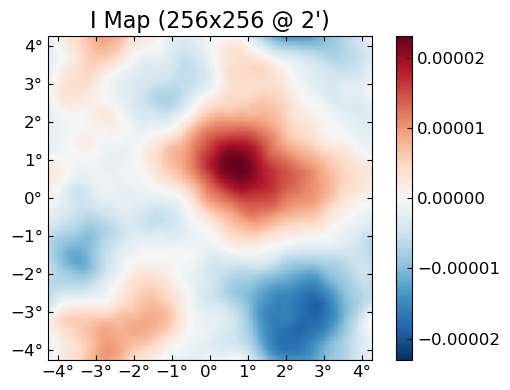

In [20]:
plot(ϕ);

For non-CMBLensing objects, this plot function will just pass-through to matplotlib, so will not affect affect your session otherwise.

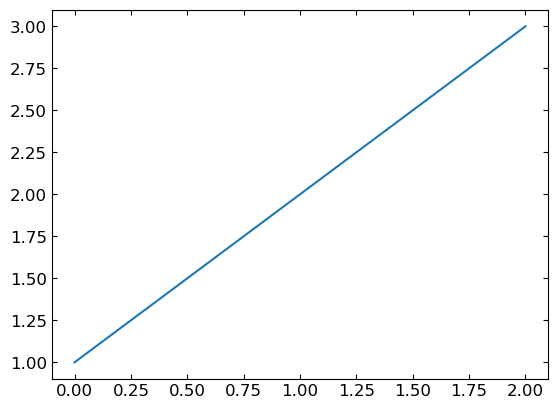

In [21]:
plot([1,2,3]);